# Regression model for Launceston

Build a RF regression model for floor height predition in Launceston.

* Use floor height between 0 and 2m as training
* Tune with cross validation
* Apply the model to all council provided points to generate final model
* Apply final model to wagga to test transferability

In [1]:
import geopandas as gpd

from matplotlib import pyplot as plt
import os

import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

from xgboost import XGBRegressor


In [2]:
pd.set_option('display.max_columns', None)

In [3]:
df_footprint = gpd.read_file('/Users/Fangyuan/FrontierSI/Projects - Documents/Projects - Data Analytics/127 Residential Dwelling Floor Height/4 Executing/Data Exploration/data_model/v1/launceston_ffh_aux_info_norm.gpkg')

In [4]:
df_footprint.head()

,gnaf_id,gnaf_address,min_building_height_ahd,max_building_height_ahd,dataset,method,storey,floor_height_m,accuracy,lid,index,nexis_wall_type,generic_ext_wall,local_year_built,nexis_year_built,nexis_construction_type,flood_vulnerability_function_id,dem,sa1,ufi,use,rows,sa11,zone,gvuln,gvulv,area_m,check1,count_,suburb,address,easting,lcc_type,northing,postcode,sa1_code,sa2_code,local_use,point_x_1,point_y_1,renaissa0,renaissa1,abs_busreg,feature_na,gcc_code_2,lga_code_2,local_foot,local_roof,local_wall,local_year,mb_code_20,min_object,nexis_bloc,nexis_cad1,nexis_cad_,nexis_cons,nexis_floo,nexis_foot,nexis_no_1,nexis_roof,nexis_use1,nexis_use_,nexis_wall,nexis_year,settlement,survey_bas,survey_c_1,survey_c_2,survey_chi,survey_com,survey_g_1,survey_gab,survey_gar,survey_grd,survey_ind,survey_nr_,survey_par,survey_res,survey_roo,survey_wal,vulnerabil,geometry
0,GATAS702215823,"68 CLARK STREET, MOWBRAY, TAS 7248",27.162,27.592,NEXIS,Modelled,0,0.459,50.0,GATAS718488148,199525.0,Fibre Cement,lightweight_cladding,1955,1952 - 1961,SH,FCM1,NaN,NaN,NaN,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,NaN,None,NaN,NaN,None,NaN,NaN,None,None,NaN,None,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,None,None,None,None,None,None,None,NaN,None,None,NaN,None,None,None,NaN,NaN,None,NaN,None,NaN,None,None,NaN,"POLYGON ((147.14326 -41.40849, 147.14344 -41.4..."
1,GATAS718488148,"67 CRAWFORD STREET, MOWBRAY, TAS 7248",27.162,27.592,NEXIS,Modelled,0,0.459,50.0,GATAS718488148,199525.0,Fibre Cement,lightweight_cladding,1955,1952 - 1961,SH,FCM1,NaN,NaN,NaN,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,NaN,None,NaN,NaN,None,NaN,NaN,None,None,NaN,None,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,None,None,None,None,None,None,None,NaN,None,None,NaN,None,None,None,NaN,NaN,None,NaN,None,NaN,None,None,NaN,"POLYGON ((147.14326 -41.40849, 147.14344 -41.4..."
2,GATAS702326215,"42-44 RACECOURSE CRESCENT, LAUNCESTON, TAS 7250",4.875,5.330,NEXIS,Modelled,0,3.327,50.0,GATAS702491447,193568.0,Timber,lightweight_cladding,2019,2017 - 2021,SH,FCM1,NaN,NaN,NaN,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,NaN,None,NaN,NaN,None,NaN,NaN,None,None,NaN,None,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,None,None,None,None,None,None,None,NaN,None,None,NaN,None,None,None,NaN,NaN,None,NaN,None,NaN,None,None,NaN,"POLYGON ((147.14955 -41.43122, 147.14948 -41.4..."
3,GATAS702471130,"42 RACECOURSE CRESCENT, LAUNCESTON, TAS 7250",4.875,5.330,NEXIS,Modelled,0,3.327,50.0,GATAS702491447,193568.0,Timber,lightweight_cladding,2019,2017 - 2021,SH,FCM1,NaN,NaN,NaN,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,NaN,None,NaN,NaN,None,NaN,NaN,None,None,NaN,None,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,None,None,None,None,None,None,None,NaN,None,None,NaN,None,None,None,NaN,NaN,None,NaN,None,NaN,None,None,NaN,"POLYGON ((147.14955 -41.43122, 147.14948 -41.4..."
4,GATAS702491447,"44 RACECOURSE CRESCENT, LAUNCESTON, TAS 7250",4.875,5.330,NEXIS,Modelled,0,3.327,50.0,GATAS702491447,193568.0,Timber,lightweight_cladding,2019,2017 - 2021,SH,FCM1,NaN,NaN,NaN,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,NaN,None,NaN,NaN,None,NaN,NaN,None,None,NaN,None,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,None,None,None,None,None,None,None,NaN,None,None,NaN,None,None,None,NaN,NaN,None,NaN,None,NaN,None,None,NaN,"POLYGON ((147.14955 -41.43122, 147.14948 -41.4..."


In [5]:
df_lcc = df_footprint[df_footprint.dataset=='LC_Final.shp']
df_nexis = df_footprint[df_footprint.dataset=='NEXIS']

In [6]:
df_lcc.head()

,gnaf_id,gnaf_address,min_building_height_ahd,max_building_height_ahd,dataset,method,storey,floor_height_m,accuracy,lid,index,nexis_wall_type,generic_ext_wall,local_year_built,nexis_year_built,nexis_construction_type,flood_vulnerability_function_id,dem,sa1,ufi,use,rows,sa11,zone,gvuln,gvulv,area_m,check1,count_,suburb,address,easting,lcc_type,northing,postcode,sa1_code,sa2_code,local_use,point_x_1,point_y_1,renaissa0,renaissa1,abs_busreg,feature_na,gcc_code_2,lga_code_2,local_foot,local_roof,local_wall,local_year,mb_code_20,min_object,nexis_bloc,nexis_cad1,nexis_cad_,nexis_cons,nexis_floo,nexis_foot,nexis_no_1,nexis_roof,nexis_use1,nexis_use_,nexis_wall,nexis_year,settlement,survey_bas,survey_c_1,survey_c_2,survey_chi,survey_com,survey_g_1,survey_gab,survey_gar,survey_grd,survey_ind,survey_nr_,survey_par,survey_res,survey_roo,survey_wal,vulnerabil,geometry
16753,GATAS702460235,"UNIT 12 86 HOLBROOK STREET, INVERMAY, TAS 7248",1.518,1.763,LC_Final.shp,Step counting,0,1.68,50.0,GNAF_GATAS702461311,NaN,None,None,None,None,None,None,1.356833,6.020110e+10,648.0,Residential,1.0,6.020110e+10,11.0 Inner Residential,3.0,9.0,104.517890,0.0,1.0,INVERMAY,86 HOLBROOK STREET,511154.441374,hsebk,5.414259e+06,7248,6.020110e+10,602011036.0,R31 - Conjoined units,147.133488,-41.423146,None,None,0.0,None,0.0,64010.0,105.082901,GI - Galvanised Iron,BKV - Brick Veneer,1982.0,6.008660e+10,700.0,4573.531820,0.0,1491900_511202_5414266_55,SD,105.082901,105.082901,1,Metal Sheeting,Residential,Large Town,Veneer Masonry,1982 - 1986,Large Town,0.0,0,None,0.0,None,SoG,N,0.0,2.4,None,1.0,N,0.0,Metal sheeting,Veneer masonry,8.0,"POLYGON ((147.13460 -41.42297, 147.13469 -41.4..."
16754,GATAS702451599,"UNIT 11 86 HOLBROOK STREET, INVERMAY, TAS 7248",1.518,1.763,LC_Final.shp,Step counting,0,1.68,50.0,GNAF_GATAS702461311,NaN,None,None,None,None,None,None,1.356833,6.020110e+10,648.0,Residential,1.0,6.020110e+10,11.0 Inner Residential,3.0,9.0,104.517890,0.0,1.0,INVERMAY,86 HOLBROOK STREET,511154.441374,hsebk,5.414259e+06,7248,6.020110e+10,602011036.0,R31 - Conjoined units,147.133488,-41.423146,None,None,0.0,None,0.0,64010.0,105.082901,GI - Galvanised Iron,BKV - Brick Veneer,1982.0,6.008660e+10,700.0,4573.531820,0.0,1491900_511202_5414266_55,SD,105.082901,105.082901,1,Metal Sheeting,Residential,Large Town,Veneer Masonry,1982 - 1986,Large Town,0.0,0,None,0.0,None,SoG,N,0.0,2.4,None,1.0,N,0.0,Metal sheeting,Veneer masonry,8.0,"POLYGON ((147.13460 -41.42297, 147.13469 -41.4..."
16755,GATAS718336363,"99-103 HOLBROOK STREET, INVERMAY, TAS 7248",1.270,1.720,LC_Final.shp,Step counting,0,1.68,50.0,GNAF_GATAS702475527,NaN,None,None,None,None,None,None,1.392257,6.020110e+10,514.0,Residential,1.0,6.020110e+10,11.0 Inner Residential,3.0,9.0,102.538755,0.0,1.0,INVERMAY,103 HOLBROOK STREET,511150.080607,bldbk,5.414141e+06,7248,6.020110e+10,602011036.0,R31 - Conjoined units,147.133438,-41.424214,None,None,0.0,None,0.0,64010.0,102.502602,GI - Galvanised Iron,BKV - Brick Veneer,1984.0,6.008362e+10,1836.0,4924.767722,0.0,1162225_511126_5414129_55,SH,102.502602,102.502602,1,Metal Sheeting,Residential,Large Town,Veneer Masonry,1982 - 1986,Large Town,0.0,0,None,0.0,None,SoG,Y,0.0,2.4,None,1.0,N,0.0,Metal sheeting,Veneer masonry,8.0,"POLYGON ((147.13274 -41.42428, 147.13279 -41.4..."
16756,GATAS702264068,"99-101 HOLBROOK STREET, INVERMAY, TAS 7248",1.270,1.720,LC_Final.shp,Step counting,0,1.68,50.0,GNAF_GATAS702475527,NaN,None,None,None,None,None,None,1.392257,6.020110e+10,514.0,Residential,1.0,6.020110e+10,11.0 Inner Residential,3.0,9.0,102.538755,0.0,1.0,INVERMAY,103 HOLBROOK STREET,511150.080607,bldbk,5.414141e+06,7248,6.020110e+10,602011036.0,R31 - Conjoined units,147.133438,-41.424214,None,None,0.0,None,0.0,64010.0,102.502602,GI - Galvanised Iron,BKV - Brick Veneer,1984.0,6.008362e+10,1836.0,4924.767722,0.0,1162225_511126_5414129_55,SH,102.502602,102.502602,1,Metal Sheeting,Residential,Large Town,Veneer Masonry,1982 - 1986,Large Town,0.0,0,None,0.0,None,SoG,Y,0.0,2.4,None,1.0,N,0.0,M

In [7]:
df_footprint.columns

Index(['gnaf_id', 'gnaf_address', 'min_building_height_ahd',
       'max_building_height_ahd', 'dataset', 'method', 'storey',
       'floor_height_m', 'accuracy', 'lid', 'index', 'nexis_wall_type',
       'generic_ext_wall', 'local_year_built', 'nexis_year_built',
       'nexis_construction_type', 'flood_vulnerability_function_id', 'dem',
       'sa1', 'ufi', 'use', 'rows', 'sa11', 'zone', 'gvuln', 'gvulv', 'area_m',
       'check1', 'count_', 'suburb', 'address', 'easting', 'lcc_type',
       'northing', 'postcode', 'sa1_code', 'sa2_code', 'local_use',
       'point_x_1', 'point_y_1', 'renaissa0', 'renaissa1', 'abs_busreg',
       'feature_na', 'gcc_code_2', 'lga_code_2', 'local_foot', 'local_roof',
       'local_wall', 'local_year', 'mb_code_20', 'min_object', 'nexis_bloc',
       'nexis_cad1', 'nexis_cad_', 'nexis_cons', 'nexis_floo', 'nexis_foot',
       'nexis_no_1', 'nexis_roof', 'nexis_use1', 'nexis_use_', 'nexis_wall',
       'nexis_year', 'settlement', 'survey_bas', 'survey_c_

In [8]:
df_merged = pd.merge(df_lcc, df_nexis, on='gnaf_id', how='inner') 

In [9]:
# remove duplicated points; likely due to footprint not seperating individual houses
df_footprint = df_merged[~df_merged['gnaf_id'].duplicated(keep=False)]

In [10]:
# Compare council and nexis data
df_footprint[['nexis_year_x','nexis_year_built_y', 'dem_x', 'floor_height_m_x','floor_height_m_y', 'min_building_height_ahd_x', 'min_building_height_ahd_y']]

,nexis_year_x,nexis_year_built_y,dem_x,floor_height_m_x,floor_height_m_y,min_building_height_ahd_x,min_building_height_ahd_y
14,1914 - 1946,2017 - 2021,3.585574,4.20,0.421,3.37,3.37
15,1914 - 1946,2017 - 2021,1.116128,1.96,0.438,1.05,1.05
16,1914 - 1946,1914 - 1946,1.299167,1.96,0.749,1.11,1.11
17,1914 - 1946,2017 - 2021,1.262290,1.96,2.493,1.09,1.09
18,1914 - 1946,2017 - 2021,1.208750,1.96,0.600,1.11,1.11
...,...,...,...,...,...,...,...
838,1914 - 1946,1914 - 1946,1.935887,2.40,0.280,1.79,1.79
839,1891 - 1913,1891 - 1913,1.346487,2.04,1.624,1.25,1.25
840,1891 - 1913,1891 - 1913,1.346487,2.04,1.624,1.25,1.25
841,1891 - 1913,1891 - 1913,1.346487,2.04,1.624,1.25,1.25


In [11]:
# Use only points matched to footprint
#df_footprint = gpd.read_file('launceston_FFH_footprint_geometry.geojson')

In [12]:
df_footprint.head()

,gnaf_id,gnaf_address_x,min_building_height_ahd_x,max_building_height_ahd_x,dataset_x,method_x,storey_x,floor_height_m_x,accuracy_x,lid_x,index_x,nexis_wall_type_x,generic_ext_wall_x,local_year_built_x,nexis_year_built_x,nexis_construction_type_x,flood_vulnerability_function_id_x,dem_x,sa1_x,ufi_x,use_x,rows_x,sa11_x,zone_x,gvuln_x,gvulv_x,area_m_x,check1_x,count__x,suburb_x,address_x,easting_x,lcc_type_x,northing_x,postcode_x,sa1_code_x,sa2_code_x,local_use_x,point_x_1_x,point_y_1_x,renaissa0_x,renaissa1_x,abs_busreg_x,feature_na_x,gcc_code_2_x,lga_code_2_x,local_foot_x,local_roof_x,local_wall_x,local_year_x,mb_code_20_x,min_object_x,nexis_bloc_x,nexis_cad1_x,nexis_cad__x,nexis_cons_x,nexis_floo_x,nexis_foot_x,nexis_no_1_x,nexis_roof_x,nexis_use1_x,nexis_use__x,nexis_wall_x,nexis_year_x,settlement_x,survey_bas_x,survey_c_1_x,survey_c_2_x,survey_chi_x,survey_com_x,survey_g_1_x,survey_gab_x,survey_gar_x,survey_grd_x,survey_ind_x,survey_nr__x,survey_par_x,survey_res_x,survey_roo_x,survey_wal_x,vulnerabil_x,geometry_x,gnaf_address_y,min_building_height_ahd_y,max_building_height_ahd_y,dataset_y,method_y,storey_y,floor_height_m_y,accuracy_y,lid_y,index_y,nexis_wall_type_y,generic_ext_wall_y,local_year_built_y,nexis_year_built_y,nexis_construction_type_y,flood_vulnerability_function_id_y,dem_y,sa1_y,ufi_y,use_y,rows_y,sa11_y,zone_y,gvuln_y,gvulv_y,area_m_y,check1_y,count__y,suburb_y,address_y,easting_y,lcc_type_y,northing_y,postcode_y,sa1_code_y,sa2_code_y,local_use_y,point_x_1_y,point_y_1_y,renaissa0_y,renaissa1_y,abs_busreg_y,feature_na_y,gcc_code_2_y,lga_code_2_y,local_foot_y,local_roof_y,local_wall_y,local_year_y,mb_code_20_y,min_object_y,nexis_bloc_y,nexis_cad1_y,nexis_cad__y,nexis_cons_y,nexis_floo_y,nexis_foot_y,nexis_no_1_y,nexis_roof_y,nexis_use1_y,nexis_use__y,nexis_wall_y,nexis_year_y,settlement_y,survey_bas_y,survey_c_1_y,survey_c_2_y,survey_chi_y,survey_com_y,survey_g_1_y,survey_gab_y,survey_gar_y,survey_grd_y,survey_ind_y,survey_nr__y,survey_par_y,survey_res_y,survey_roo_y,survey_wal_y,vulnerabil_y,geometry_y
14,GATAS702223569,"10 EDDINGTON CRESCENT, INVERMAY, TAS 7248",3.37,3.67,LC_Final.shp,Step counting,0,4.20,50.0,GNAF_GATAS702223569,NaN,None,None,None,None,None,None,3.585574,6.020110e+10,936.0,Residential,1.0,6.020110e+10,10.0 General Residential,4.0,10.0,118.721187,0.0,1.0,INVERMAY,10 EDDINGTON CRESCENT,511012.312293,hsewb,5.415364e+06,7248,6.020110e+10,602011036.0,R1 - House or Cottage,147.131767,-41.413199,None,None,0.0,None,0.0,64010.0,118.770500,GI - Galvanised Iron,WB - Weatherboard,1927.0,6.008895e+10,364.0,515.794346,0.0,2427482_511009_5415367_55,SH,118.770500,118.770500,1,Metal Sheeting,Residential,Large Town,Timber,1914 - 1946,Large Town,0.0,Medium,None,1.0,None,RTF,yes,0.0,2.7,None,1.0,no,0.0,Metal Sheeting,Weatherboard,1.0,"POLYGON ((147.13175 -41.41326, 147.13185 -41.4...","10 EDDINGTON CRESCENT, INVERMAY, TAS 7248",3.37,3.67,NEXIS,Modelled,0,0.421,50.0,GATAS702223569,198396.0,Timber,lightweight_cladding,2017,2017 - 2021,SH,FCM1,NaN,NaN,NaN,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,NaN,None,NaN,NaN,None,NaN,NaN,None,None,NaN,None,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,None,None,None,None,None,None,None,NaN,None,None,NaN,None,None,None,NaN,NaN,None,NaN,None,NaN,None,None,NaN,"POLYGON ((147.13175 -41.41326, 147.13185 -41.4..."
15,GATAS702235784,"11 DARWIN STREET, INVERMAY, TAS 7248",1.05,1.24,LC_Final.shp,Step counting,0,1.96,50.0,GNAF_GATAS702235784,NaN,None,None,None,None,None,None,1.116128,6.020110e+10,438.0,Residential,1.0,6.020110e+10,11.0 Inner Residential,1.0,7.0,100.358132,0.0,1.0,INVERMAY,11 DARWIN STREET,510828.878497,hsewb,5.414031e+06,7248,6.020110e+10,602011036.0,R1 - House or Cottage,147.129596,-41.425204,None,None,0.0,None,0.0,64010.0,100.023903,GI - Galvanised Iron,WB - Weatherboard,1925.0,6.008426e+10,220.0,441.600902,0.0,2160091_510830_5414024_55,SH,100.023903,100.023903,1,Metal Sheeting,Residential,Large Town,Timber,1914 - 1946,Large Town,0.0,0,None

In [13]:
df_footprint['range_dem_y'] = df_footprint['max_building_height_ahd_y'] - df_footprint['min_building_height_ahd_y']

/Users/Fangyuan/miniconda/envs/geo/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [14]:
# Council floor height as target variable
df_footprint['floor_height_m'] = df_footprint['floor_height_m_x'] - df_footprint['dem_x']

/Users/Fangyuan/miniconda/envs/geo/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [15]:
df_footprint['min_building_height_ahd_y'] = df_footprint['min_building_height_ahd_y'] - df_footprint['min_building_height_ahd_y'].min()

In [16]:
len(df_footprint)

677

### Inspect and clean up categorical fields 

Ensure no duplication in categorical fields. If necessary, make all lower case; take first letter to combine y/yes, n/no etc

In [17]:
cate_cols = ['NEXIS_CONSTRUCTION_TYPE', 'NEXIS_YEAR_BUILT', 'NEXIS_WALL_TYPE', 'GENERIC_EXT_WALL', 'flood_vulnerability_function_id']
cate_cols = [col.lower()+'_y' for col in cate_cols]
print(cate_cols)
for col in cate_cols:
    #df_footprint[col] = df_footprint[col].str.lower()
    print(df_footprint[col].unique())

['nexis_construction_type_y', 'nexis_year_built_y', 'nexis_wall_type_y', 'generic_ext_wall_y', 'flood_vulnerability_function_id_y']
['SH']
['2017 - 2021' '1914 - 1946' '1891 - 1913' '2002 - 2006' '1840 - 1890'
 '1952 - 1961' '2007 - 2011' '1947 - 1951' '1992 - 1996' '2012 - 2016'
 '1962 - 1971' '1972 - 1976' '2022 - 2026' '1997 - 2001']
['Timber' 'Fibre Cement' 'Veneer Masonry' 'Cavity and Solid Masonry'
 'RC or RM' 'Metal Sheeting' 'Precast Concrete']
['lightweight_cladding' 'brick_veneer' 'cavity_masonry']
['FCM1' 'FCM7' 'FCM10' 'FCM5' 'FCM3' 'FCM6' 'FCM11' 'FCM9' 'FCM8' 'FCM4']


In [18]:
df_footprint[cate_cols].describe()

,nexis_construction_type_y,nexis_year_built_y,nexis_wall_type_y,generic_ext_wall_y,flood_vulnerability_function_id_y
count,677,677,677,677,677
unique,1,14,7,3,10
top,SH,2017 - 2021,Timber,lightweight_cladding,FCM1
freq,677,363,490,572,513


## Build and tune a regression model

* Use selected catagorical and numerical featrures
* Remove highly correlated features


In [19]:
# Features and target
cat_features = ['NEXIS_YEAR_BUILT','NEXIS_CONSTRUCTION_TYPE', 'NEXIS_WALL_TYPE', 'GENERIC_EXT_WALL', 'flood_vulnerability_function_id']#, 'Survey_G_1']
cat_features = [col.lower()+'_y' for col in cat_features]
num_features = ['range_dem','min_building_height_ahd']#, 'LOCAL_YEAR']#, 'max_building_height_ahd'] #,'range_dem_2'] #,'range_dem_2']#, 'LOCAL_YEAR']#, 'range_dem_2']
num_features = [col.lower()+'_y' for col in num_features]
target = 'floor_height_m'

X_raw = df_footprint[cat_features + num_features]
y = df_footprint[target]

# One-hot encode categorical variables
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder.fit(X_raw[cat_features])

# Normalize numeric features
scaler = StandardScaler()
scaler.fit(X_raw[num_features])

# Apply the tranformation
X_encoded_categorical = encoder.transform(X_raw[cat_features])
X_normalized_numeric = scaler.transform(X_raw[num_features])

# Concatenate the encoded categorical features with the normalized numeric features
X = np.hstack((X_encoded_categorical, X_normalized_numeric))


In [20]:
ffh_limit = 2

In [21]:
# Remove outliers
X_lt_2m = X[(df_footprint[target]>=0).values & (df_footprint[target]<ffh_limit).values]
y_lt_2m = y[(df_footprint[target]>=0).values & (df_footprint[target]<ffh_limit).values]

In [22]:
# Helper function to remove highly correlated features
def remove_highly_correlated_features(X, threshold=0.9):
    corr_matrix = pd.DataFrame(X).corr().abs()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]
    return X.drop(columns=to_drop, axis=1)

# Custom transformer to integrate with pipeline
from sklearn.base import BaseEstimator, TransformerMixin

class CorrelationFilter(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.9):
        self.threshold = threshold
        self.to_drop = None

    def fit(self, X, y=None):
        X_df = pd.DataFrame(X)
        corr_matrix = X_df.corr().abs()
        upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        self.to_keep = [column for column in X_df.columns if not any(upper_triangle[column] > self.threshold)]
        return self

    def transform(self, X, y=None):
        return pd.DataFrame(X).loc[:, self.to_keep] if self.to_keep else X


In [23]:
# Bin the target variable into 10 bins
y_binned = pd.cut(y_lt_2m, bins=10, labels=False)

# Count the frequency of each bin
bin_counts = pd.value_counts(y_binned)

# Calculate weights based on frequency of each bin
# Inverse frequency as the weight (you can tweak this)
weights = np.array([1 / bin_counts[label]**2 for label in y_binned])

#weights = np.where((y_binned>1) & (y_binned<5), 1, 10000)


/var/folders/20/1jhcj5794rq6bfzc4mnnx51r0000gp/T/ipykernel_73586/2481863291.py:5: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  bin_counts = pd.value_counts(y_binned)


In [24]:
# Use all data (less than 2m FFH) to tune and find best model

# Pipeline including CorrelationFilter
pipeline = Pipeline([
    ('correlation_filter', CorrelationFilter(threshold=0.8)),
    #('regressor', XGBRegressor()),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Hyperparameter grid for Random Forest
param_grid = {
    'regressor__n_estimators': [50, 100, 200, 300],
    'regressor__max_depth': [5, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    #'regressor__min_samples_leaf': [1, 2],
    'regressor__max_features': ['sqrt', 'log2']
}

# XGB
#param_grid = {
#    'regressor__n_estimators': [50, 100, 200],
#    'regressor__learning_rate': [0.01, 0.1, 0.2],
#    'regressor__max_depth': [3, 5, 7],
#    'regressor__subsample': [0.8, 0.9, 1.0],
#}


# Bin the target variable into 10 bins
y_binned = pd.cut(y_lt_2m, bins=5, labels=False)

# Define a stratified k-fold splitter based on the binned target
stratified_splitter = StratifiedKFold(n_splits=3, shuffle=True, random_state=24)

# Cross-validation with GridSearch
grid_search = GridSearchCV(pipeline, param_grid, cv=stratified_splitter.split(X_lt_2m, y_binned), scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_lt_2m, y_lt_2m, regressor__sample_weight=weights)

# Best model from GridSearch
best_model = grid_search.best_estimator_

# Output best parameters and RMSE on full dataset
print("Best Parameters:", grid_search.best_params_)
print("Training RMSE:", np.sqrt(mean_squared_error(y, best_model.predict(X))))

Best Parameters: {'regressor__max_depth': 30, 'regressor__max_features': 'sqrt', 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100}
Training RMSE: 0.4566976105449555


In [25]:
# Extract feature importances after correlation filter
remaining_features = best_model.named_steps['correlation_filter'].to_keep
feature_importances = best_model.named_steps['regressor'].feature_importances_
# Get the feature names (assuming you have them stored somewhere)
cat_feature_names = np.array(encoder.get_feature_names_out())
all_feature_names = np.concatenate((cat_feature_names, num_features))[remaining_features]
print("Total number of features encoded:", len(cat_feature_names)+len(num_features))
print("Total number of features kept:", len(all_feature_names))

# Create a DataFrame for easy viewing
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importances.round(3)
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

Total number of features encoded: 37
Total number of features kept: 34
                                       Feature  Importance
33                   min_building_height_ahd_y       0.281
32                                 range_dem_y       0.264
1               nexis_year_built_y_1891 - 1913       0.109
12              nexis_year_built_y_2017 - 2021       0.072
7               nexis_year_built_y_1992 - 1996       0.033
21            nexis_wall_type_y_Veneer Masonry       0.032
23      flood_vulnerability_function_id_y_FCM1       0.029
16              nexis_wall_type_y_Fibre Cement       0.024
20                    nexis_wall_type_y_Timber       0.023
22     generic_ext_wall_y_lightweight_cladding       0.017
15  nexis_wall_type_y_Cavity and Solid Masonry       0.017
28      flood_vulnerability_function_id_y_FCM5       0.013
0               nexis_year_built_y_1840 - 1890       0.013
10              nexis_year_built_y_2007 - 2011       0.011
30      flood_vulnerability_function_id_y_FC

### Apply model to survey data and all data points

This model overfits

Explained Variance (R^2): 0.8866
RMSE: 0.08083578656246455


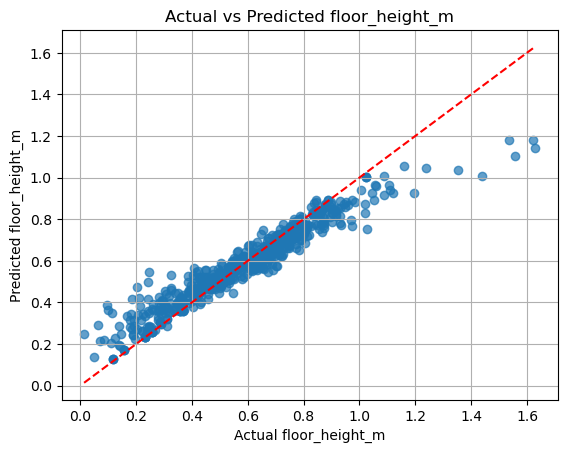

In [26]:
# Fit the best model on all data points
best_model.fit(X_lt_2m, y_lt_2m, regressor__sample_weight=weights)


# Get predictions for all data points
predictions = best_model.predict(X_lt_2m)

# Calculate explained variance
explained_variance = r2_score(y_lt_2m, predictions)
print(f"Explained Variance (R^2): {explained_variance:.4f}")

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_lt_2m, predictions))
print(f"RMSE: {rmse}")

plt.scatter(y_lt_2m, predictions, alpha=0.7)
plt.plot([y_lt_2m.min(), y_lt_2m.max()], [y_lt_2m.min(), y_lt_2m.max()], 'r--')  # Diagonal line
plt.title(f'Actual vs Predicted {target}')
plt.xlabel(f'Actual {target}')
plt.ylabel(f'Predicted {target}')
plt.grid(True)

RMSE: 0.06298229673540012


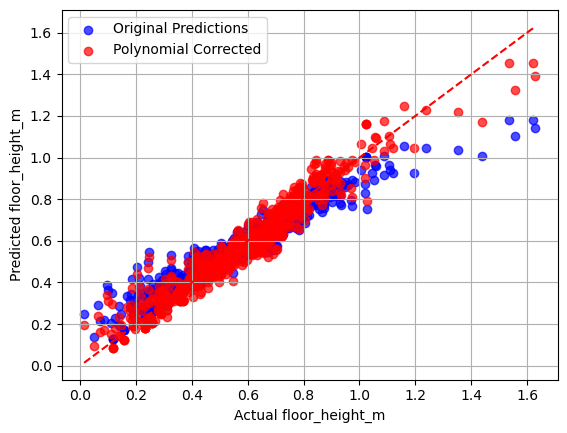

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Assuming y and y_pred are already defined
# y = true target values
# y_pred = predicted values from your RandomForestRegressor

# Generate polynomial features (degree can be adjusted)
poly = PolynomialFeatures(degree=2)  # You can try different degrees, e.g., 2, 3, etc.
poly.fit(predictions.reshape(-1, 1))
y_pred_poly = poly.transform(predictions.reshape(-1, 1))

# Fit a linear regression model to the polynomial features
poly_model = LinearRegression()
poly_model.fit(y_pred_poly, y_lt_2m)

# Predict the corrected values using the polynomial model
y_pred_corrected = poly_model.predict(y_pred_poly)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_lt_2m, y_pred_corrected))
print(f"RMSE: {rmse}")

# Plotting the original vs corrected predictions for visualization
plt.scatter(y_lt_2m, predictions, color='blue', label='Original Predictions', alpha=0.7)
plt.scatter(y_lt_2m, y_pred_corrected, color='red', label='Polynomial Corrected', alpha=0.7)
plt.plot([y_lt_2m.min(), y_lt_2m.max()], [y_lt_2m.min(), y_lt_2m.max()], 'r--')  # Diagonal line
plt.xlabel(f'Actual {target}')
plt.ylabel(f'Predicted {target}')
plt.grid(True)
plt.legend()
plt.show()


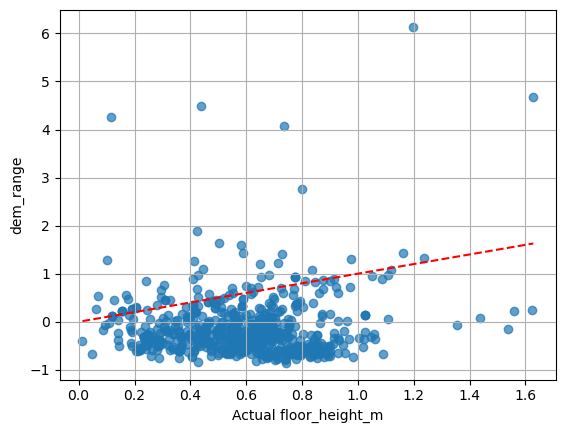

In [28]:
plt.scatter(y_lt_2m, X_lt_2m[:,len(cat_feature_names)], alpha=0.7)
plt.plot([y_lt_2m.min(), y_lt_2m.max()], [y_lt_2m.min(), y_lt_2m.max()], 'r--')  # Diagonal line
plt.xlabel(f'Actual {target}')
plt.ylabel(f'dem_range')
plt.grid(True)

Slope: 0.023519770799443895
Intercept: 0.5882554257526237


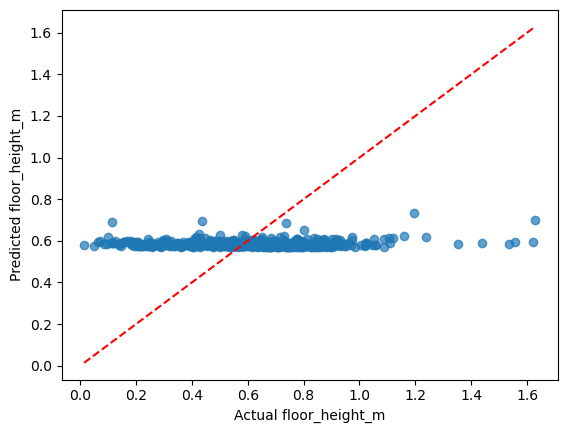

In [29]:
from sklearn.linear_model import BayesianRidge

# Fit Bayesian Ridge Regression
model = BayesianRidge()
model.fit(X_lt_2m[:,len(cat_feature_names)].reshape(-1, 1), y_lt_2m)
y_pred, y_std = model.predict(X_lt_2m[:,len(cat_feature_names)].reshape(-1, 1), return_std=True)

plt.scatter(y_lt_2m, y_pred, alpha=0.7)

plt.plot([y_lt_2m.min(), y_lt_2m.max()], [y_lt_2m.min(), y_lt_2m.max()], 'r--')  # Diagonal line
plt.xlabel(f'Actual {target}')
plt.ylabel(f'Predicted {target}')

# Model coefficients
print("Slope:", model.coef_[0])
print("Intercept:", model.intercept_)

### Train and validate using best model


Explained Variance (R^2): 0.3532
RMSE: 0.18851711951343922
RMSE (corrected): 0.1935613625900012
Explained Variance (R^2) (random): -0.9496
RMSE (random): 0.327295945019287


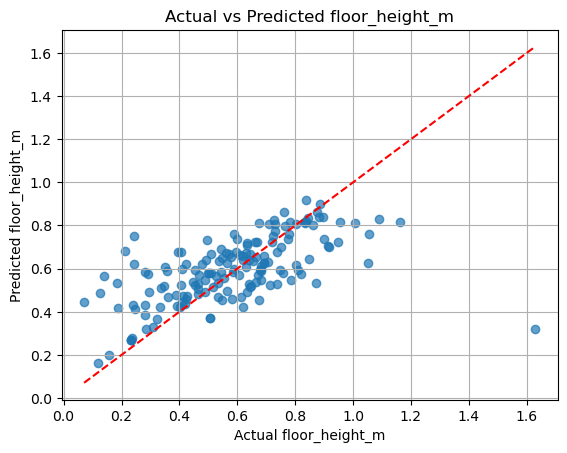

In [30]:
# Bin the target variable into 10 bins
y_binned = pd.cut(y_lt_2m, bins=10, labels=False)

# Split the dataset into training and validation sets stratified by target values
X_train, X_val, y_train, y_val, weights_train, weights_val = train_test_split(
    X_lt_2m, y_lt_2m, weights, test_size=0.25, stratify=y_binned, random_state=42
)

# Create a Random Forest Regressor model
#best_model = Pipeline([
#    ('correlation_filter', CorrelationFilter(threshold=0.8)),
#    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42, max_depth=30)) #, max_features='sqrt', min_samples_split=2)
#])

#X_train = np.vstack((X_train, X_transformed_wagga))
#y_train = np.concatenate((y_train, y_wagga))

# Fit the best model on all data points
best_model.fit(X_train, y_train, regressor__sample_weight=weights_train)

# Additional correction
predictions = best_model.predict(X_train)
# Generate polynomial features (degree can be adjusted)
poly = PolynomialFeatures(degree=2)  # You can try different degrees, e.g., 2, 3, etc.
poly.fit(predictions.reshape(-1, 1))
y_pred_poly = poly.transform(predictions.reshape(-1, 1))

# Fit a linear regression model to the polynomial features
poly_model = LinearRegression()
poly_model.fit(y_pred_poly, y_train)

# Get predictions for all data points
predictions = best_model.predict(X_val)
# Additional correction
y_pred_poly = poly.transform(predictions.reshape(-1, 1))
predictions_corrected = poly_model.predict(y_pred_poly)

# Calculate explained variance
explained_variance = r2_score(y_val, predictions)
print(f"Explained Variance (R^2): {explained_variance:.4f}")

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val, predictions))
print(f"RMSE: {rmse}")

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val, predictions_corrected))
print(f"RMSE (corrected): {rmse}")

plt.scatter(y_val, predictions, alpha=0.7)
#plt.scatter(y_val, predictions_corrected, alpha=0.7)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')  # Diagonal line
plt.title(f'Actual vs Predicted {target}')
plt.xlabel(f'Actual {target}')
plt.ylabel(f'Predicted {target}')
plt.grid(True)

# Compare to random
pred_random = np.random.choice(y_val, size=len(y_val), replace=True)
explained_variance = r2_score(y_val, pred_random)
print(f"Explained Variance (R^2) (random): {explained_variance:.4f}")
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val, pred_random))
print(f"RMSE (random): {rmse}")

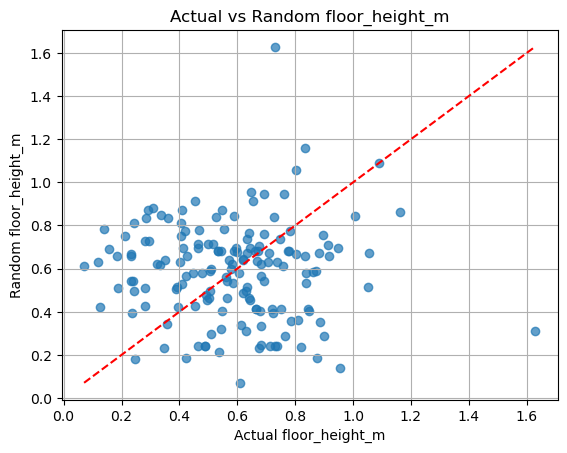

In [31]:
plt.scatter(y_val, pred_random, alpha=0.7)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')  # Diagonal line
plt.title(f'Actual vs Random {target}')
plt.xlabel(f'Actual {target}')
plt.ylabel(f'Random {target}')
plt.grid(True)

## Apply to Wagga Wagga

In [32]:
df_wagga = gpd.read_file('/Users/Fangyuan/FrontierSI/Projects - Documents/Projects - Data Analytics/127 Residential Dwelling Floor Height/4 Executing/Data Exploration/data_model/v1/wagga_ffh_aux_info_norm.gpkg')

In [33]:
df_wagga_cc = df_wagga[df_wagga.dataset=='Wagga_Building_Estimated_Levels_floor_heights.geojson']
df_wagga_nexis = df_wagga[df_wagga.dataset=='NEXIS']
df_merged = pd.merge(df_wagga_cc, df_wagga_nexis, on='gnaf_id', how='inner')
df_wagga = df_merged[~df_merged['gnaf_id'].duplicated(keep=False)]

In [34]:
df_wagga['range_dem_y'] = df_wagga['max_building_height_ahd_y'] - df_wagga['min_building_height_ahd_y']

/Users/Fangyuan/miniconda/envs/geo/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [35]:
multiples = np.isclose(df_wagga.floor_height_m_x.values, 0.28, atol=1e-3)
for i in np.arange(2, df_wagga.floor_height_m_x.max()/0.28+1):
    multiples = multiples | np.isclose(df_wagga.floor_height_m_x.values, 0.28*i, atol=1e-3)

print("# of Multiples of 0.28:",multiples.sum())
df_wagga = df_wagga[~multiples]
df_wagga = df_wagga[df_wagga['floor_height_m_x'] <2 ]

# of Multiples of 0.28: 2699


In [36]:
df_wagga['min_building_height_ahd_y'] = df_wagga['min_building_height_ahd_y'] - df_wagga['min_building_height_ahd_y'].min()

Explained Variance (R^2): -0.0164
RMSE: 0.31239330762053014
Explained Variance (R^2) (random): -0.9881
RMSE (random): 0.4369048525940909


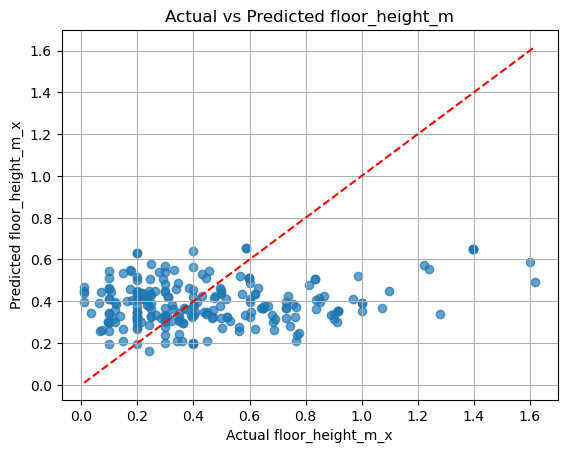

In [37]:
#df_wagga = gpd.read_file('wagga_FFH_footprint_geometry.geojson')
#df_wagga = df_wagga[df_wagga['surveyed'].values & (df_wagga['Floor_Height']<2).values]
#df_wagga['range_dem'] = df_wagga['max_height_ahd'] - df_wagga['min_height_ahd']

# Features and target
#at_features_wagga = []#'NEXIS_YEAR_BUILT','NEXIS_CONSTRUCTION_TYPE', 'NEXIS_WALL_TYPE', 'GENERIC_EXT_WALL', 'flood_vulnerability_function_id'] # 'Survey_G_1'
#num_features_wagga = ['range_dem','min_height_ahd']#, 'max_height_ahd' ]#,'range_dem_2'] #,'range_dem_2']#, 'LOCAL_YEAR']#, 'range_dem_2']
#target_wagga = 'Floor_Height'

# Create a mapping dictionary from old to new column names
#rename_mapping = dict(zip(cat_features_wagga+num_features_wagga, cat_features+num_features))
# Rename the columns in df_footprint
#df_wagga.rename(columns=rename_mapping, inplace=True)

target_wagga = 'floor_height_m_x'
X_wagga = df_wagga[cat_features + num_features]
y_wagga = df_wagga[target_wagga]

# Apply the tranformation
X_encoded_wagga = encoder.transform(X_wagga[cat_features])
X_normalized_wagga = scaler.transform(X_wagga[num_features])

# Concatenate the encoded categorical features with the normalized numeric features
X_transformed_wagga = np.hstack((X_encoded_wagga, X_normalized_wagga))


# Get predictions for all data points
predictions_wagga = best_model.predict(X_transformed_wagga)

# Correct additional bias
#y_pred_poly = poly.transform(predictions_wagga.reshape(-1, 1))
#predictions_wagga = poly_model.predict(y_pred_poly)

# Calculate explained variance
explained_variance = r2_score(y_wagga, predictions_wagga)
print(f"Explained Variance (R^2): {explained_variance:.4f}")

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_wagga, predictions_wagga))
print(f"RMSE: {rmse}")

plt.scatter(y_wagga, predictions_wagga, alpha=0.7)
plt.plot([y_wagga.min(), y_wagga.max()], [y_wagga.min(), y_wagga.max()], 'r--')  # Diagonal line
plt.title(f'Actual vs Predicted {target}')
plt.xlabel(f'Actual {target_wagga}')
plt.ylabel(f'Predicted {target_wagga}')
plt.grid(True)

# Compare to random
pred_random_wagga = np.random.choice(y_wagga, size=len(y_wagga), replace=True)
explained_variance = r2_score(y_wagga, pred_random_wagga)
print(f"Explained Variance (R^2) (random): {explained_variance:.4f}")
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_wagga, pred_random_wagga))
print(f"RMSE (random): {rmse}")



In [38]:
len(y_wagga)

227

Slope: -0.001378182606089982
Intercept: 0.44441810199222603


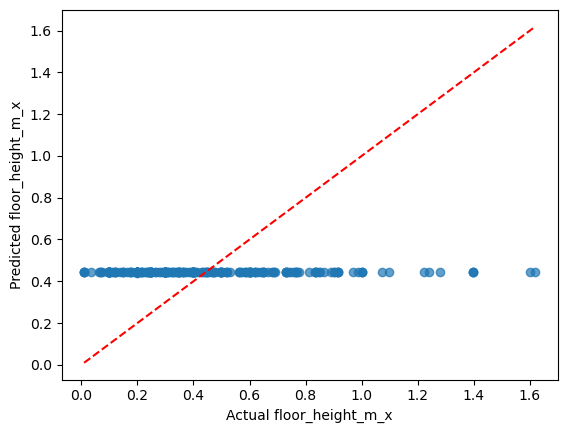

In [40]:
from sklearn.linear_model import BayesianRidge

X_wagga = df_wagga[['range_dem_y']]
# Fit Bayesian Ridge Regression
model = BayesianRidge()
model.fit(X_wagga, y_wagga)
y_pred, y_std = model.predict(X_wagga, return_std=True)

plt.scatter(y_wagga, y_pred, alpha=0.7)

plt.plot([y_wagga.min(), y_wagga.max()], [y_wagga.min(), y_wagga.max()], 'r--')  # Diagonal line
plt.xlabel(f'Actual {target_wagga}')
plt.ylabel(f'Predicted {target_wagga}')

# Model coefficients
print("Slope:", model.coef_[0])
print("Intercept:", model.intercept_)

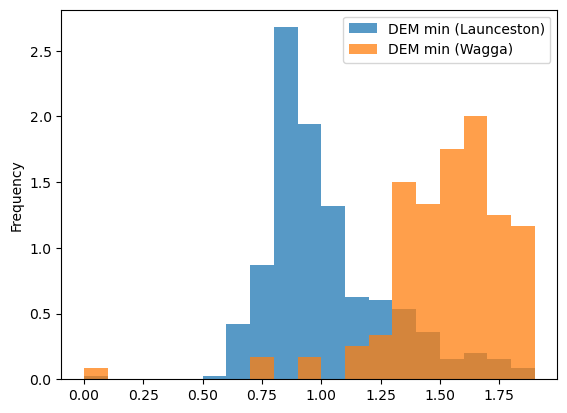

In [41]:
(df_footprint['min_building_height_ahd_y']-df_footprint['min_building_height_ahd_y'].min()).plot.hist(bins=np.arange(0,2,0.1), alpha=0.75, label='DEM min (Launceston)', density=True);
(df_wagga['min_building_height_ahd_y']).plot.hist(bins=np.arange(0,2,0.1), alpha=0.75, label='DEM min (Wagga)', density=True);
plt.legend()

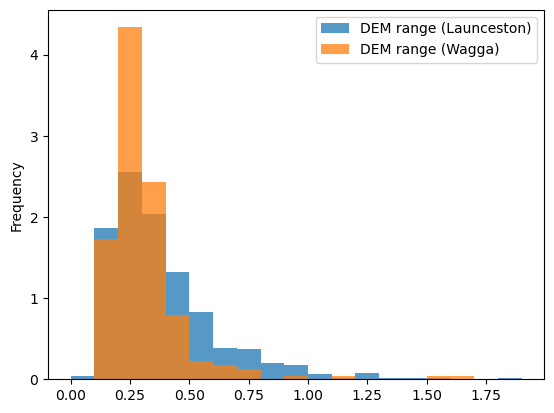

In [42]:
df_footprint['range_dem_y'].plot.hist(bins=np.arange(0,2,0.1), alpha=0.75, label='DEM range (Launceston)', density=True);
df_wagga['range_dem_y'].plot.hist(bins=np.arange(0,2,0.1), alpha=0.75, label='DEM range (Wagga)', density=True);
plt.legend()